In [1]:
import math
import torch
import torch.nn as nn

from vectorverse.sb3   import get_vec_env   
from vectorverse       import BatchedVectorFieldEnv
from stable_baselines3 import SAC 

SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# pendulum env: stabilize at theta = pi (upright)
class BatchedInvertedPendulumEnv(BatchedVectorFieldEnv):
    """
    Batched simple pendulum on a torque, continuous time, ODE-integrated.

    state  = [theta, theta_dot]
    action = [tau]

    Dynamics (unit length/mass):
        theta'      = theta_dot
        theta_dot'  = g * sin(theta) + tau - d * theta_dot

    We track  theta and set a fixed target of [pi]
    so the agent learns to stand the pendulum upright.
    """

    g = 9.81             # gravity
    d = 0.2              # damping
    DEFAULT_DT   = 0.05  # time step between observations
    DEFAULT_TF   = 50.0  # max episode length
    DEFAULT_REG  = 1e-3  # regularization weight for control cost
    DEFAULT_NOISE = 0.1  # reset noise in percents of the init_state_box range

    # solver defaults
    # check torchdiffeq.odeint for available methods
    @property
    def solver_kwargs(self):
        return {"method": "dopri5", "rtol": 1e-4, "atol": 1e-6}

    # we want a *fixed* target: upright
    @property
    def signal_gen_kwargs(self):
        # shape: (n_ticks, 1)
        values = torch.tensor([[math.pi], [math.pi]], dtype=torch.float32)
        times  = torch.tensor([0.0, self.DEFAULT_TF], dtype=torch.float32)
        return {
            "fixed_times":  times,
            "fixed_values": values,
        }

    def __init__(self,
                 num_envs: int,
                 *,
                 device: str | torch.device = "cpu",
                 render_mode: str | None = None,
                 **kwargs):
        super().__init__(
            num_envs=num_envs,
            dt=self.DEFAULT_DT,
            Tf=self.DEFAULT_TF,
            regularization=self.DEFAULT_REG,
            reset_noise=self.DEFAULT_NOISE,
            device=device,
            render_mode=render_mode,
            **kwargs
        )

    # ----- abstract API -----

    @property
    def state_box(self) -> torch.Tensor:
        # angle in [-2π, 2π], velocity in [-8, 8]
        hi = torch.tensor([2*math.pi, 8.0], device=self.device, dtype=torch.float32)
        lo = -hi
        return torch.stack([lo, hi], dim=0)

    @property
    def target_box(self) -> torch.Tensor:
        # just define a finite box for targets; we actually use fixed one = [pi]
        hi = torch.tensor([2*math.pi], device=self.device, dtype=torch.float32)
        lo = -hi
        return torch.stack([lo, hi], dim=0)
    
    @property
    def init_state_box(self) -> torch.Tensor:
        # start near downward position
        hi = torch.tensor([0.5, 0.5], device=self.device, dtype=torch.float32)
        lo = -hi
        return torch.stack([lo, hi], dim=0)

    @property
    def action_box(self) -> torch.Tensor:
        # torque ∈ [-2, 2]
        hi = torch.tensor([2.0], device=self.device, dtype=torch.float32)
        lo = -hi
        return torch.stack([lo, hi], dim=0)

    @property
    def output_mask(self) -> torch.Tensor:
        # track angle only
        return torch.tensor([True, False], device=self.device, dtype=torch.bool)

    def vector_field(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        theta, theta_dot = state.unbind(dim=-1)     # (N,), (N,)
        tau = action.squeeze(-1)                    # (N,)

        theta_dot_new = theta_dot
        # simple pendulum, upright at pi → sin(theta) term will push it around
        theta_ddot_new = self.g * torch.sin(theta) + tau - self.d * theta_dot

        # render any full episode if available and clear render queue
        if self.render_mode is not None:
            self.render()
            self.render_clear()
        return torch.stack([theta_dot_new, theta_ddot_new], dim=-1)


In [3]:
# 2. helper to wrap into SB3 VecEnv + callback

def make_vec(env):
    # wrap into SB3 VecEnv with VecNormalize (universal builder)
    return get_vec_env(
        env,
        seed=SEED,
        num_envs=None,  # env is already batched
        vec_norm=False, # we don't use VecNormalize
    )


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 238      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3965     |
|    time_elapsed    | 8        |
|    total_timesteps | 32032    |
| train/             |          |
|    actor_loss      | -4.16    |
|    critic_loss     | 0.0218   |
|    ent_coef        | 0.776    |
|    ent_coef_loss   | -0.425   |
|    learning_rate   | 0.0003   |
|    n_updates       | 844      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 238      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3964     |
|    time_elapsed    | 8        |
|    total_timesteps | 32032    |
---------------------------------
---------------------------------
| rollout/           |        

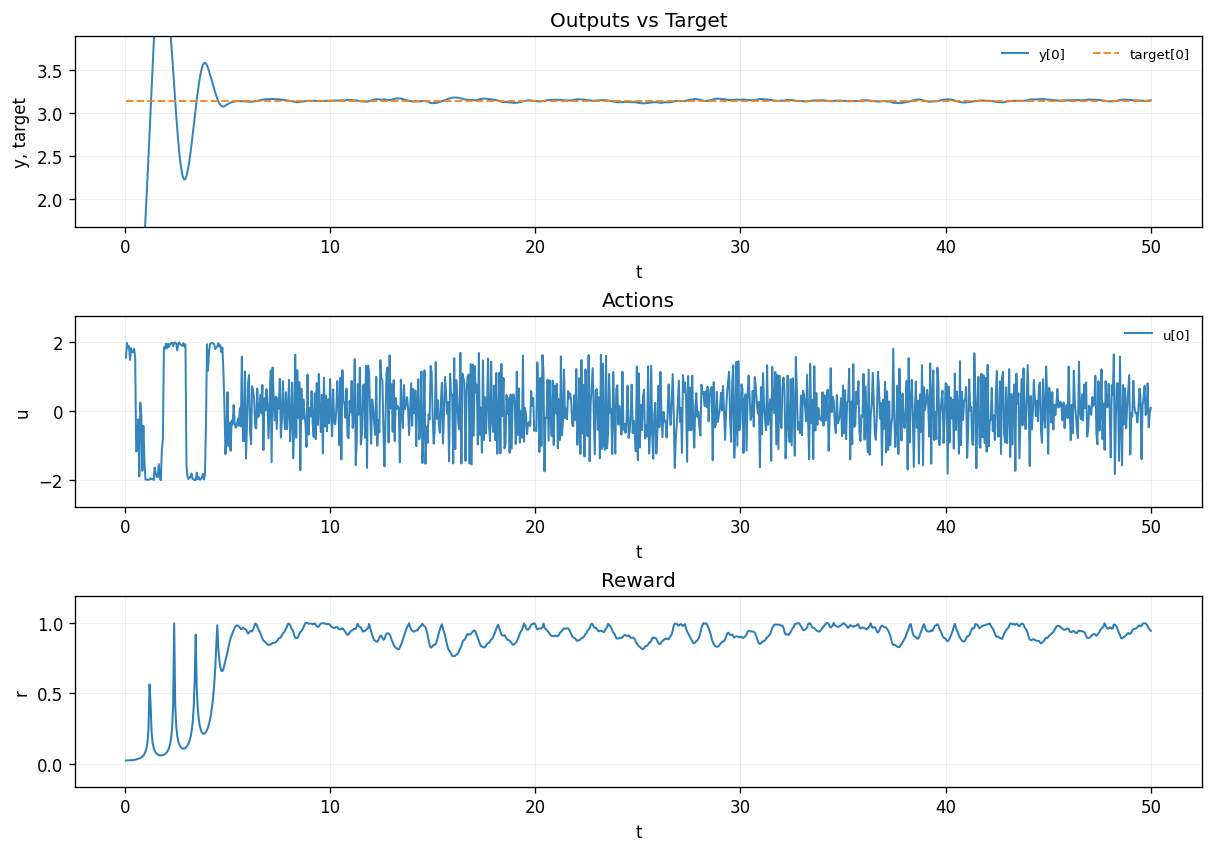

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 186      |
| time/              |          |
|    episodes        | 36       |
|    fps             | 3792     |
|    time_elapsed    | 16       |
|    total_timesteps | 64064    |
| train/             |          |
|    actor_loss      | -6.23    |
|    critic_loss     | 0.0129   |
|    ent_coef        | 0.575    |
|    ent_coef_loss   | -0.934   |
|    learning_rate   | 0.0003   |
|    n_updates       | 1845     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 186      |
| time/              |          |
|    episodes        | 40       |
|    fps             | 3792     |
|    time_elapsed    | 16       |
|    total_timesteps | 64064    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

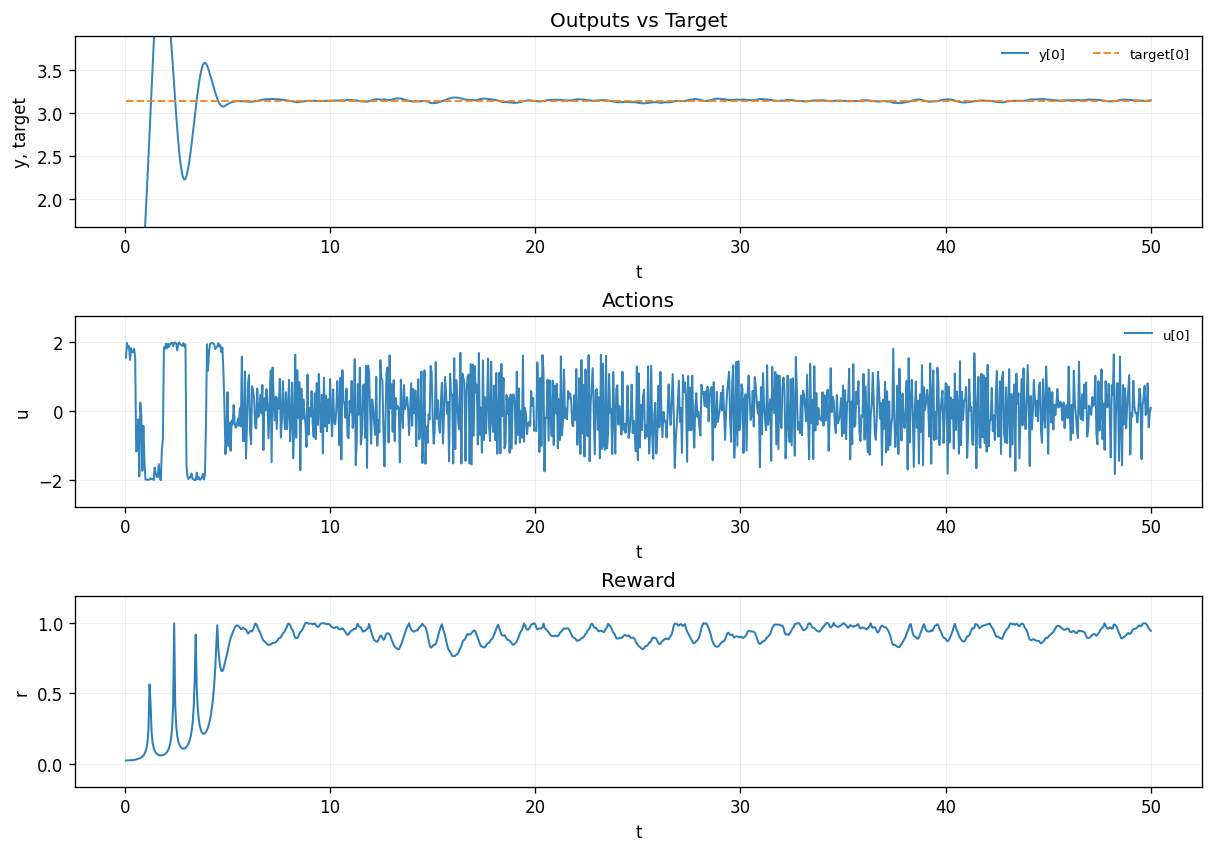

In [4]:
# 3. build env, algorithm, train
env_pend = BatchedInvertedPendulumEnv(
    num_envs=32,
    device=device, 
    render_mode="human",
)

TOTAL_TIMESTEPS = 500_000

alg_params = {
    "learning_rate": 3e-4,
    "gamma": 0.99,
    "tau": 0.005,
    "ent_coef": "auto",
    "batch_size": 256,
    "buffer_size": 500_000,
    "learning_starts": 5_000,
    "train_freq": 1,
    "gradient_steps": 1,
    "target_update_interval": 1,
    "verbose": 1,
    "seed": SEED,
    "policy_kwargs": dict(
        net_arch=[128, 128],
        activation_fn=nn.ReLU,
    ),
    "device": device,
}

model = SAC(
    "MlpPolicy",
    make_vec(env_pend),  
    **alg_params,
)

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=False,
)
